In [6]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor

from scipy.stats import pearsonr, spearmanr

from scipy.stats import pearsonr

import seaborn as sns

from matplotlib import colors

import editdistance

def subselect_list(li, ixs) :
    return [
        li[ixs[k]] for k in range(len(ixs))
    ]

class IdentityEncoder(iso.SequenceEncoder) :
    
    def __init__(self, seq_len, channel_map) :
        super(IdentityEncoder, self).__init__('identity', (seq_len, len(channel_map)))
        
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            nt: ix for ix, nt in self.encode_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            seq += self.decode_map[argmax_nt]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementError()

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#Load APA plasmid data (random mpra)
file_path = '../../../../aparent/data/apa_plasmid_data/apa_plasmid_data'

plasmid_dict = isoio.load(file_path)

plasmid_df = plasmid_dict['plasmid_df']
plasmid_cuts = plasmid_dict['plasmid_cuts']

print("len(plasmid_df) = " + str(len(plasmid_df)))


len(plasmid_df) = 3818077


In [3]:
#Filter data
kept_libraries = [22]
min_count = 20

if kept_libraries is not None :
    keep_index = np.nonzero(plasmid_df.library_index.isin(kept_libraries))[0]
    plasmid_df = plasmid_df.iloc[keep_index].copy()
    plasmid_cuts = plasmid_cuts[keep_index, :]

if min_count is not None :
    keep_index = np.nonzero(plasmid_df.total_count >= min_count)[0]
    plasmid_df = plasmid_df.iloc[keep_index].copy()
    plasmid_cuts = plasmid_cuts[keep_index, :]

print("len(plasmid_df) = " + str(len(plasmid_df)) + " (filtered)")


len(plasmid_df) = 487402 (filtered)


In [4]:
#Calculate isoform ratios and log odds

pseudo_c = 1.0

prox_c = np.ravel(plasmid_cuts[:, 180+80:180+80+25].sum(axis=-1))
total_c = np.ravel(plasmid_cuts[:, 180:180+205].sum(axis=-1)) + np.ravel(plasmid_cuts[:, -1].todense())

plasmid_df['proximal_count_from_cuts'] = prox_c + pseudo_c
plasmid_df['total_count_from_cuts'] = total_c + 2. * pseudo_c

plasmid_df['proximal_usage'] = plasmid_df['proximal_count_from_cuts'] / plasmid_df['total_count_from_cuts']
plasmid_df['proximal_logodds'] = np.log(plasmid_df['proximal_usage'] / (1. - plasmid_df['proximal_usage']))


In [5]:
#Shuffle dataset and pick 50,000 datapoints for the test set

n_test = 50000

shuffle_index = np.arange(len(plasmid_df))
np.random.shuffle(shuffle_index)

plasmid_df_shuffled = plasmid_df.iloc[shuffle_index].copy().reset_index(drop=True)

plasmid_df_train = plasmid_df_shuffled.iloc[:-n_test].copy().reset_index(drop=True)
plasmid_df_test = plasmid_df_shuffled.iloc[-n_test:].copy().reset_index(drop=True)


In [7]:
#Get list of sequences and measured values

use_cached_version = True

seqs_train = None
seqs_test = None
y_train = None
y_test = None

if use_cached_version :
    seqs_train = pd.read_csv("apa_simple_seqs_train.csv", sep="\t")["seq"].values.tolist()
    seqs_test = pd.read_csv("apa_simple_seqs_test.csv", sep="\t")["seq"].values.tolist()
    y_train = np.ravel(pd.read_csv("apa_simple_seqs_train.csv", sep="\t")["logodds"].values)
    y_test = np.ravel(pd.read_csv("apa_simple_seqs_test.csv", sep="\t")["logodds"].values)
else :
    seqs_train = plasmid_df_train['padded_seq'].str.slice(180+25-5, 180+25+147+5).values.tolist()
    seqs_test = plasmid_df_test['padded_seq'].str.slice(180+25-5, 180+25+147+5).values.tolist()

    logodds_train = plasmid_df_train['proximal_logodds'].values.tolist()
    logodds_test = plasmid_df_test['proximal_logodds'].values.tolist()

    seqs_train_df = pd.DataFrame({'seq' : seqs_train, 'logodds' : logodds_train})
    seqs_train_df.to_csv("apa_simple_seqs_train.csv", sep="\t", index=False)

    seqs_test_df = pd.DataFrame({'seq' : seqs_test, 'logodds' : logodds_test})
    seqs_test_df.to_csv("apa_simple_seqs_test.csv", sep="\t", index=False)

print("len(seqs_train) = " + str(len(seqs_train)))
print("len(seqs_test) = " + str(len(seqs_test)))


len(seqs_train) = 437402
len(seqs_test) = 50000


In [8]:
#Extract subsequences, train

h50a_pad_5_train = [seqs_train[i][0:55] for i in range(len(seqs_train))]
h50a_pad_3_train = [seqs_train[i][0 + 2:55 - 2] for i in range(len(seqs_train))]
h50a_pad_1_train = [seqs_train[i][0 + 4:55 - 4] for i in range(len(seqs_train))]

pas_1_train = [seqs_train[i][50:50 + 6] for i in range(len(seqs_train))]

h50b_pad_5_train = [seqs_train[i][45 + 6: 45 + 6 + 55] for i in range(len(seqs_train))]
h50b_pad_3_train = [seqs_train[i][45 + 6 + 2: 45 + 6 + 55 - 2] for i in range(len(seqs_train))]
h50b_pad_1_train = [seqs_train[i][45 + 6 + 4: 45 + 6 + 55 - 4] for i in range(len(seqs_train))]

pas_2_train = [seqs_train[i][50 + 45 + 6:50 + 45 + 6 + 6] for i in range(len(seqs_train))]

h50c_pad_5_train = [seqs_train[i][45 + 6 + 45 + 6: 45 + 6 + 45 + 6 + 55] for i in range(len(seqs_train))]
h50c_pad_3_train = [seqs_train[i][45 + 6 + 45 + 6 + 2: 45 + 6 + 45 + 6 + 55 - 2] for i in range(len(seqs_train))]
h50c_pad_1_train = [seqs_train[i][45 + 6 + 45 + 6 + 4: 45 + 6 + 45 + 6 + 55 - 4] for i in range(len(seqs_train))]

#Extract subsequences, test

h50a_pad_5_test = [seqs_test[i][0:55] for i in range(len(seqs_test))]
h50a_pad_3_test = [seqs_test[i][0 + 2:55 - 2] for i in range(len(seqs_test))]
h50a_pad_1_test = [seqs_test[i][0 + 4:55 - 4] for i in range(len(seqs_test))]

pas_1_test = [seqs_test[i][50:50 + 6] for i in range(len(seqs_test))]

h50b_pad_5_test = [seqs_test[i][45 + 6: 45 + 6 + 55] for i in range(len(seqs_test))]
h50b_pad_3_test = [seqs_test[i][45 + 6 + 2: 45 + 6 + 55 - 2] for i in range(len(seqs_test))]
h50b_pad_1_test = [seqs_test[i][45 + 6 + 4: 45 + 6 + 55 - 4] for i in range(len(seqs_test))]

pas_2_test = [seqs_test[i][50 + 45 + 6:50 + 45 + 6 + 6] for i in range(len(seqs_test))]

h50c_pad_5_test = [seqs_test[i][45 + 6 + 45 + 6: 45 + 6 + 45 + 6 + 55] for i in range(len(seqs_test))]
h50c_pad_3_test = [seqs_test[i][45 + 6 + 45 + 6 + 2: 45 + 6 + 45 + 6 + 55 - 2] for i in range(len(seqs_test))]
h50c_pad_1_test = [seqs_test[i][45 + 6 + 45 + 6 + 4: 45 + 6 + 45 + 6 + 55 - 4] for i in range(len(seqs_test))]


In [9]:
#Compute k-mer count matrices

use_cached_version = True

sparse_mer2_encoder = isol.SparseBatchEncoder(isol.NMerEncoder(n_mer_len=2, count_n_mers=True))
sparse_mer4_encoder = isol.SparseBatchEncoder(isol.NMerEncoder(n_mer_len=4, count_n_mers=True))
sparse_mer6_encoder = isol.SparseBatchEncoder(isol.NMerEncoder(n_mer_len=6, count_n_mers=True))

#Initialize counts, train
h50a_mer2_train = None
h50a_mer4_train = None
h50a_mer6_train = None

cano_pas_1_train = None

h50b_mer2_train = None
h50b_mer4_train = None
h50b_mer6_train = None

cano_pas_2_train = None

h50c_mer2_train = None
h50c_mer4_train = None
h50c_mer6_train = None

#Initialize counts, test
h50a_mer2_test = None
h50a_mer4_test = None
h50a_mer6_test = None

cano_pas_1_test = None

h50b_mer2_test = None
h50b_mer4_test = None
h50b_mer6_test = None

cano_pas_2_test = None

h50c_mer2_test = None
h50c_mer4_test = None
h50c_mer6_test = None

if use_cached_version :
    #Load counts, train
    h50a_mer2_train = spio.loadmat("apa_simple_h50a_mer2_counts_train.mat")["h50a_mer2_train"]
    h50a_mer4_train = spio.loadmat("apa_simple_h50a_mer4_counts_train.mat")["h50a_mer4_train"]
    h50a_mer6_train = spio.loadmat("apa_simple_h50a_mer6_counts_train.mat")["h50a_mer6_train"]

    cano_pas_1_train = spio.loadmat("apa_simple_cano_pas_1_train.mat")["cano_pas_1_train"]

    h50b_mer2_train = spio.loadmat("apa_simple_h50b_mer2_counts_train.mat")["h50b_mer2_train"]
    h50b_mer4_train = spio.loadmat("apa_simple_h50b_mer4_counts_train.mat")["h50b_mer4_train"]
    h50b_mer6_train = spio.loadmat("apa_simple_h50b_mer6_counts_train.mat")["h50b_mer6_train"]

    cano_pas_2_train = spio.loadmat("apa_simple_cano_pas_2_train.mat")["cano_pas_2_train"]

    h50c_mer2_train = spio.loadmat("apa_simple_h50c_mer2_counts_train.mat")["h50c_mer2_train"]
    h50c_mer4_train = spio.loadmat("apa_simple_h50c_mer4_counts_train.mat")["h50c_mer4_train"]
    h50c_mer6_train = spio.loadmat("apa_simple_h50c_mer6_counts_train.mat")["h50c_mer6_train"]

    #Load counts, test
    h50a_mer2_test = spio.loadmat("apa_simple_h50a_mer2_counts_test.mat")["h50a_mer2_test"]
    h50a_mer4_test = spio.loadmat("apa_simple_h50a_mer4_counts_test.mat")["h50a_mer4_test"]
    h50a_mer6_test = spio.loadmat("apa_simple_h50a_mer6_counts_test.mat")["h50a_mer6_test"]

    cano_pas_1_test = spio.loadmat("apa_simple_cano_pas_1_test.mat")["cano_pas_1_test"]

    h50b_mer2_test = spio.loadmat("apa_simple_h50b_mer2_counts_test.mat")["h50b_mer2_test"]
    h50b_mer4_test = spio.loadmat("apa_simple_h50b_mer4_counts_test.mat")["h50b_mer4_test"]
    h50b_mer6_test = spio.loadmat("apa_simple_h50b_mer6_counts_test.mat")["h50b_mer6_test"]

    cano_pas_2_test = spio.loadmat("apa_simple_cano_pas_2_test.mat")["cano_pas_2_test"]

    h50c_mer2_test = spio.loadmat("apa_simple_h50c_mer2_counts_test.mat")["h50c_mer2_test"]
    h50c_mer4_test = spio.loadmat("apa_simple_h50c_mer4_counts_test.mat")["h50c_mer4_test"]
    h50c_mer6_test = spio.loadmat("apa_simple_h50c_mer6_counts_test.mat")["h50c_mer6_test"]
else :
    #Encode subsequence counts, train
    h50a_mer2_train = sparse_mer2_encoder(h50a_pad_1_train)
    h50a_mer4_train = sparse_mer4_encoder(h50a_pad_3_train)
    h50a_mer6_train = sparse_mer6_encoder(h50a_pad_5_train)

    cano_pas_1_train = sp.csr_matrix(np.array([1 if pas_1_train[i] == 'AATAAA' else 0 for i in range(len(pas_1_train))]).reshape(-1, 1))

    h50b_mer2_train = sparse_mer2_encoder(h50b_pad_1_train)
    h50b_mer4_train = sparse_mer4_encoder(h50b_pad_3_train)
    h50b_mer6_train = sparse_mer6_encoder(h50b_pad_5_train)

    cano_pas_2_train = sp.csr_matrix(np.array([1 if pas_2_train[i] == 'AATAAA' else 0 for i in range(len(pas_2_train))]).reshape(-1, 1))

    h50c_mer2_train = sparse_mer2_encoder(h50c_pad_1_train)
    h50c_mer4_train = sparse_mer4_encoder(h50c_pad_3_train)
    h50c_mer6_train = sparse_mer6_encoder(h50c_pad_5_train)

    #Encode subsequence counts, test
    h50a_mer2_test = sparse_mer2_encoder(h50a_pad_1_test)
    h50a_mer4_test = sparse_mer4_encoder(h50a_pad_3_test)
    h50a_mer6_test = sparse_mer6_encoder(h50a_pad_5_test)

    cano_pas_1_test = sp.csr_matrix(np.array([1 if pas_1_test[i] == 'AATAAA' else 0 for i in range(len(pas_1_test))]).reshape(-1, 1))

    h50b_mer2_test = sparse_mer2_encoder(h50b_pad_1_test)
    h50b_mer4_test = sparse_mer4_encoder(h50b_pad_3_test)
    h50b_mer6_test = sparse_mer6_encoder(h50b_pad_5_test)

    cano_pas_2_test = sp.csr_matrix(np.array([1 if pas_2_test[i] == 'AATAAA' else 0 for i in range(len(pas_2_test))]).reshape(-1, 1))

    h50c_mer2_test = sparse_mer2_encoder(h50c_pad_1_test)
    h50c_mer4_test = sparse_mer4_encoder(h50c_pad_3_test)
    h50c_mer6_test = sparse_mer6_encoder(h50c_pad_5_test)

    #Save counts, train
    spio.savemat("apa_simple_h50a_mer2_counts_train.mat", {"h50a_mer2_train" : h50a_mer2_train})
    spio.savemat("apa_simple_h50a_mer4_counts_train.mat", {"h50a_mer4_train" : h50a_mer4_train})
    spio.savemat("apa_simple_h50a_mer6_counts_train.mat", {"h50a_mer6_train" : h50a_mer6_train})

    spio.savemat("apa_simple_cano_pas_1_train.mat", {"cano_pas_1_train" : cano_pas_1_train})

    spio.savemat("apa_simple_h50b_mer2_counts_train.mat", {"h50b_mer2_train" : h50b_mer2_train})
    spio.savemat("apa_simple_h50b_mer4_counts_train.mat", {"h50b_mer4_train" : h50b_mer4_train})
    spio.savemat("apa_simple_h50b_mer6_counts_train.mat", {"h50b_mer6_train" : h50b_mer6_train})

    spio.savemat("apa_simple_cano_pas_2_train.mat", {"cano_pas_2_train" : cano_pas_2_train})

    spio.savemat("apa_simple_h50c_mer2_counts_train.mat", {"h50c_mer2_train" : h50c_mer2_train})
    spio.savemat("apa_simple_h50c_mer4_counts_train.mat", {"h50c_mer4_train" : h50c_mer4_train})
    spio.savemat("apa_simple_h50c_mer6_counts_train.mat", {"h50c_mer6_train" : h50c_mer6_train})

    #Save counts, test
    spio.savemat("apa_simple_h50a_mer2_counts_test.mat", {"h50a_mer2_test" : h50a_mer2_test})
    spio.savemat("apa_simple_h50a_mer4_counts_test.mat", {"h50a_mer4_test" : h50a_mer4_test})
    spio.savemat("apa_simple_h50a_mer6_counts_test.mat", {"h50a_mer6_test" : h50a_mer6_test})

    spio.savemat("apa_simple_cano_pas_1_test.mat", {"cano_pas_1_test" : cano_pas_1_test})

    spio.savemat("apa_simple_h50b_mer2_counts_test.mat", {"h50b_mer2_test" : h50b_mer2_test})
    spio.savemat("apa_simple_h50b_mer4_counts_test.mat", {"h50b_mer4_test" : h50b_mer4_test})
    spio.savemat("apa_simple_h50b_mer6_counts_test.mat", {"h50b_mer6_test" : h50b_mer6_test})

    spio.savemat("apa_simple_cano_pas_2_test.mat", {"cano_pas_2_test" : cano_pas_2_test})

    spio.savemat("apa_simple_h50c_mer2_counts_test.mat", {"h50c_mer2_test" : h50c_mer2_test})
    spio.savemat("apa_simple_h50c_mer4_counts_test.mat", {"h50c_mer4_test" : h50c_mer4_test})
    spio.savemat("apa_simple_h50c_mer6_counts_test.mat", {"h50c_mer6_test" : h50c_mer6_test})

print("h50a_mer2_train.shape = " + str(h50a_mer2_train.shape))
print("h50a_mer2_test.shape = " + str(h50a_mer2_test.shape))


h50a_mer2_train.shape = (437402, 16)
h50a_mer2_test.shape = (50000, 16)


In [10]:
#Create concatenated (log) feature data matrix

mer_train = sp.csr_matrix(sp.hstack([
    h50a_mer2_train,
    h50a_mer4_train,
    h50a_mer6_train,
    cano_pas_1_train,
    h50b_mer2_train,
    h50b_mer4_train,
    h50b_mer6_train,
    cano_pas_2_train,
    h50c_mer2_train,
    h50c_mer4_train,
    h50c_mer6_train,
]))

mer_test = sp.csr_matrix(sp.hstack([
    h50a_mer2_test,
    h50a_mer4_test,
    h50a_mer6_test,
    cano_pas_1_test,
    h50b_mer2_test,
    h50b_mer4_test,
    h50b_mer6_test,
    cano_pas_2_test,
    h50c_mer2_test,
    h50c_mer4_test,
    h50c_mer6_test,
]))


log_mer_train = sp.coo_matrix(mer_train.copy())
log_mer_train.data = np.log2(1. + log_mer_train.data)
log_mer_train = sp.csr_matrix(log_mer_train)

log_mer_test = sp.coo_matrix(mer_test.copy())
log_mer_test.data = np.log2(1. + log_mer_test.data)
log_mer_test = sp.csr_matrix(log_mer_test)

print("log_mer_train.shape = " + str(log_mer_train.shape))
print("log_mer_test.shape = " + str(log_mer_test.shape))


log_mer_train.shape = (437402, 13106)
log_mer_test.shape = (50000, 13106)


In [11]:
#Train a sparse k-mer lasso model (k-mer feature selection step)

use_cached_version = True

n_train_subset = 100000
l1_alpha = 0.003

if use_cached_version :
    mer_lasso = pickle.load(open("apa_simple_mer246_lasso_l1_alpha_" + str(l1_alpha).replace(".", "_") + "_n_train_" + str(n_train_subset) + ".pickle", "rb"))["mer6_lasso"]
else :
    shuffle_index = np.arange(log_mer_train.shape[0])
    np.random.shuffle(shuffle_index)

    mer_lasso = linear_model.Lasso(alpha=l1_alpha).fit(log_mer_train[shuffle_index[:n_train_subset]], y_train[shuffle_index[:n_train_subset]])
    
    pickle.dump({
        "mer6_lasso" : mer_lasso,
        "mer6_lasso.intercept_" : mer_lasso.intercept_,
        "mer6_lasso.coef_" : mer_lasso.coef_
    }, open("apa_simple_mer246_lasso_l1_alpha_" + str(l1_alpha).replace(".", "_") + "_n_train_" + str(n_train_subset) + ".pickle", "wb"))

print("# nonzero coefficients (lasso) = " + str(len(mer_lasso.coef_[mer_lasso.coef_ != 0.])))


# nonzero coefficients (lasso) = 420


In [13]:
#Train an L2-regularized linear model using features discovered earlier (de-biasing step)

use_cached_version = True

l2_alpha = 0.0

nonzero_feat_ix = np.nonzero(mer_lasso.coef_)[0]

if use_cached_version :
    mer_linear = pickle.load(open("apa_simple_mer246_linear_l2_alpha_" + str(l2_alpha).replace(".", "_") + ".pickle", "rb"))["mer6_linear"]
else :
    mer_linear = linear_model.Ridge(alpha=l2_alpha).fit(log_mer_train[:, nonzero_feat_ix], y_train[:])
    
    pickle.dump({
        "mer6_linear" : mer_linear,
        "nonzero_feat_ix" : nonzero_feat_ix,
        "mer6_linear.intercept_" : mer_linear.intercept_,
        "mer6_linear.coef_" : mer_linear.coef_
    }, open("apa_simple_mer246_linear_l2_alpha_" + str(l2_alpha).replace(".", "_") + ".pickle", "wb"))

print("# nonzero coeffs = " + str(len(mer_linear.coef_[mer_linear.coef_ != 0.])))


# nonzero coeffs = 420


-- K-mer Linear Model (Training data) --
pearson-r correlation = 0.7126
pearson-r p = 0.0


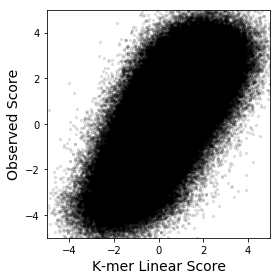

-- K-mer Linear Model (Test data) --
pearson-r correlation = 0.713
pearson-r p = 0.0


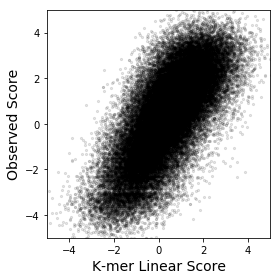

In [15]:
#Predict on data using linear k-mer model

print("-- K-mer Linear Model (Training data) --")

y_train_hat = mer_linear.predict(log_mer_train[:, nonzero_feat_ix])

print("pearson-r correlation = " + str(round(pearsonr(y_train_hat, y_train)[0], 4)))
print("pearson-r p = " + str(round(pearsonr(y_train_hat, y_train)[1], 4)))

f = plt.figure(figsize=(4, 4))

plt.scatter(y_train_hat, y_train, s=5, color='black', alpha=0.1)

plt.xlim(-5, 5)
plt.ylim(-5, 5)

plt.xlabel("K-mer Linear Score", fontsize=14)
plt.ylabel("Observed Score", fontsize=14)

plt.tight_layout()
plt.show()

print("-- K-mer Linear Model (Test data) --")

y_test_hat = mer_linear.predict(log_mer_test[:, nonzero_feat_ix])

print("pearson-r correlation = " + str(round(pearsonr(y_test_hat, y_test)[0], 4)))
print("pearson-r p = " + str(round(pearsonr(y_train_hat, y_train)[1], 4)))

f = plt.figure(figsize=(4, 4))

plt.scatter(y_test_hat, y_test, s=5, color='black', alpha=0.1)

plt.xlim(-5, 5)
plt.ylim(-5, 5)

plt.xlabel("K-mer Linear Score", fontsize=14)
plt.ylabel("Observed Score", fontsize=14)

plt.tight_layout()
plt.show()


In [16]:
#Train a boosted k-mer ensemble using features discovered earlier

use_cached_version = True

n_estimators = 256
max_depth = 5

nonzero_feat_ix = np.nonzero(mer_lasso.coef_)[0]

if use_cached_version :
    boosted_grad = pickle.load(open("apa_simple_mer246_boosted_grad_n_estimators_" + str(n_estimators) + "_max_depth_" + str(max_depth) + "_n_features_" + str(len(nonzero_feat_ix)) + ".pickle", "rb"))["boosted_grad"]
else :
    boosted_grad = GradientBoostingRegressor(
        n_estimators=n_estimators,
        learning_rate=0.1,
        max_depth=max_depth,
        loss='ls',
        verbose=1
    ).fit(
        np.array(log_mer_train[:, nonzero_feat_ix].todense()),
        y_train
    )
    
    pickle.dump({
        "boosted_grad" : boosted_grad
    }, open("apa_simple_mer246_boosted_grad_n_estimators_" + str(n_estimators) + "_max_depth_" + str(max_depth) + "_n_features_" + str(len(nonzero_feat_ix)) + ".pickle", "wb"))

print(boosted_grad)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=256, presort='auto', random_state=None,
             subsample=1.0, verbose=1, warm_start=False)


-- Boosted K-mer Model (Training data) --
pearson-r correlation = 0.7408
pearson-r p = 0.0


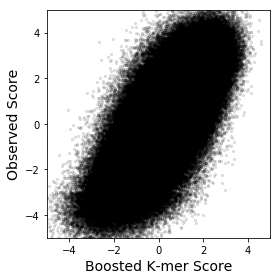

-- Boosted K-mer Model (Test data) --
pearson-r correlation = 0.7297
pearson-r p = 0.0


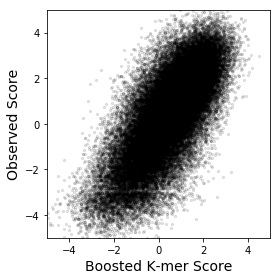

In [18]:
#Predict on data using boosted k-mer model

print("-- Boosted K-mer Model (Training data) --")

y_train_hat = boosted_grad.predict(log_mer_train[:, nonzero_feat_ix])

print("pearson-r correlation = " + str(round(pearsonr(y_train_hat, y_train)[0], 4)))
print("pearson-r p = " + str(round(pearsonr(y_train_hat, y_train)[1], 4)))

f = plt.figure(figsize=(4, 4))

plt.scatter(y_train_hat, y_train, s=5, color='black', alpha=0.1)

plt.xlim(-5, 5)
plt.ylim(-5, 5)

plt.xlabel("Boosted K-mer Score", fontsize=14)
plt.ylabel("Observed Score", fontsize=14)

plt.tight_layout()
plt.show()

print("-- Boosted K-mer Model (Test data) --")

y_test_hat = boosted_grad.predict(log_mer_test[:, nonzero_feat_ix])

print("pearson-r correlation = " + str(round(pearsonr(y_test_hat, y_test)[0], 4)))
print("pearson-r p = " + str(round(pearsonr(y_train_hat, y_train)[1], 4)))

f = plt.figure(figsize=(4, 4))

plt.scatter(y_test_hat, y_test, s=5, color='black', alpha=0.1)

plt.xlim(-5, 5)
plt.ylim(-5, 5)

plt.xlabel("Boosted K-mer Score", fontsize=14)
plt.ylabel("Observed Score", fontsize=14)

plt.tight_layout()
plt.show()
